In [1]:
import sys
sys.path.append("../data_analysis_and_preparation")
from prepare_human_feedback import get_data_from_excel

In [2]:
def transform_df(df):

    if "usefullness" in df.columns:  #typo...
        df.rename(columns={"usefullness":"usefulness"}, inplace=True)

    # include the correctness in the fact-checking
    df.loc[df["correctness"]!= "Recherche nötig", "fact_check"] = df.loc[df["correctness"]!= "Recherche nötig", "correctness"]
    for i, row in df.iterrows():
        try:
            df.loc[i,] = translate_row(row)
        except KeyError:
            pass
    
    df["footnote_id"] = df.apply(lambda row: f"{row['letter_id']}_{row['n_footnote']}", axis=1) 
    
    return df

def translate_row(row):
    translator = {
        "style": {
            "Der Text ist unverständlich": "incomprehensible",
            "Der Text ist verständlich, aber stilistisch unpassend": "inadequate",
            "Der Text ist einer wissenschaftlichen Edition angemessen": "adequate"

        },
        "usefulness": {
            "Die Fussnote ist irrelevant": "irrelevant",
            "Die Fussnote ist teilweise relevant": "partially relevant",
            "Die Fussnote ist relevant": "relevant",
        },
        "correctness":{
            "Enthält Fehlinformationen": "incorrect",
            "Keine Fehlinformationen": "correct",
            "Keine Einschätzung möglich": "subjective",
            "Recherche nötig": "research required"
        }
    }
    if row.style:
        row.style = translator["style"][row.style.strip()]
    if row.usefulness:
        row.usefulness = translator["usefulness"][row.usefulness.strip()]
    if row.fact_check:
        row.fact_check = translator["correctness"][row.fact_check.strip()]
    if row.correctness:
        row.correctness = translator["correctness"][row.correctness.strip()]
    
    # write "Human" instead of text_footnote
    if row.model == "text_footnote":
        row.model = "Human"
    
    return row
    

In [3]:
import matplotlib.pyplot as plt
def plot_human_eval(df, categories=['style', 'usefulness', "correctness", 'fact_check']):
    # Group and calculate counts for each category
    # grouped_data = {cat: df.groupby(['model', cat]).size().unstack(fill_value=0) for cat in categories}
    grouped_data = {
    cat: df.groupby(['model', cat]).size().unstack(fill_value=0).apply(lambda x: (x / x.sum()) * 100, axis=1)
    for cat in categories
    }
    print(grouped_data)

    category_colors = {
    'adequate': 'blue',
    'inadequate': 'green',
    'incomprehensible': 'red',
    'irrelevant': 'red',  # Example mappings,
    "partially relevant": "green",
    "relevant": "blue",
    "correct": "blue",
    "incorrect": "red",
    "subjective": "green",
    "research required": "orange"
    }
    

    # Set up a 2x2 grid for the subplots
    if len(categories) == 4:
        fig, axes = plt.subplots(2, 2, figsize=(16, 12))
        axes = axes.flatten()  # Flatten the 2x2 array to easily iterate
    elif len(categories) == 2:
        fig, axes = plt.subplots(1, 2, figsize=(16, 6))
        axes = axes.flatten()  # Flatten the 2x2 array to easily iterate
    elif len(categories) == 1:
        fig, ax = plt.subplots(1, 1, figsize=(8, 6))
    

    if len(categories)>1:
        # Loop through each category and corresponding axis
        for idx, (cat, ax) in enumerate(zip(categories, axes)):
            grouped_data[cat].plot(
                kind='bar',
                ax=ax,
                color=category_colors,
                edgecolor='black',
                legend=True
            )
                # Rotate tick descriptions horizontally
            ax.set_xticklabels(ax.get_xticklabels(), rotation=0)
            ax.set_title(cat.replace("_", " ").title())
            ax.set_xlabel('')
            ax.set_ylabel('Percentage')
            ax.grid(True, axis="y", linestyle='--', alpha=0.6)
            # Create a custom legend for each subplot
            legend_handles, legend_labels = ax.get_legend_handles_labels()
            ax.legend(
                handles=legend_handles,
                labels=legend_labels,
                loc='lower center',
                bbox_to_anchor=(0.5, -0.15),  # Adjust position below each chart
                ncol=len(legend_handles),  # Arrange in a single row
            )
    else:
        for cat in categories:
                        grouped_data[cat].plot(
            kind='bar',
            ax=ax,
            color=category_colors,
            edgecolor='black',
            legend=True
        )
            # Rotate tick descriptions horizontally
        ax.set_xticklabels(ax.get_xticklabels(), rotation=0)
        ax.set_title(cat.replace("_", " ").title())
        ax.set_xlabel('')
        ax.set_ylabel('Percentage')
        ax.grid(True, axis="y", linestyle='--', alpha=0.6)
        # Create a custom legend for each subplot
        legend_handles, legend_labels = ax.get_legend_handles_labels()
        ax.legend(
            handles=legend_handles,
            labels=legend_labels,
            loc='lower center',
            bbox_to_anchor=(0.5, -0.15),  # Adjust position below each chart
            ncol=len(legend_handles),  # Arrange in a single row
        )


    # Adjust layout and show the plot
    plt.tight_layout()
    plt.subplots_adjust(hspace=0.25) 
    return fig



In [4]:


from scipy.stats import spearmanr, kendalltau



import pandas as pd

# Scoring dictionary
scoring = {
    'style': {'adequate': 2, 'inadequate': 1, 'incomprehensible': 0},
    'usefulness': {'relevant': 2, 'partially relevant': 1, 'irrelevant': 0}
}

# Function to rank models
def calculate_ranking(df, criteria):
    """
    Rank models by the given criteria (e.g., 'style' or 'usefulness') for each footnote_id.

    Args:
        df (pd.DataFrame): The input DataFrame containing the data.
        criteria (str): The column to use for scoring ('style' or 'usefulness').

    Returns:
        pd.DataFrame: DataFrame with rankings for each footnote_id.
    """
    if criteria not in scoring:
        raise ValueError(f"Invalid criteria '{criteria}'. Valid options are: {list(scoring.keys())}")

    # Map scores based on the scoring dictionary
    df[f'{criteria}_score'] = df[criteria].map(scoring[criteria]).fillna(0)

    # Rank models within each footnote_id
    df['rank'] = df.groupby('footnote_id')[f'{criteria}_score'].rank(ascending=False, method='dense')

    return df[['footnote_id', 'model', criteria, f'{criteria}_score', 'rank']]

def calculate_iaa_overall(dfs, criteria):
    """
    Calculate overall Inter-Annotator Agreement (IAA) for multiple annotators.
    
    Args:
        dfs (list of pd.DataFrame): List of DataFrames, one per annotator.
        criteria (str): The criteria to evaluate (e.g., 'style', 'usefulness').
        
    Returns:
        dict: Dictionary containing Kendall's Tau and Spearman's correlation for the entire dataset.
    """
    if len(dfs) < 2:
        raise ValueError("At least two DataFrames are required for IAA calculation.")

    # Rank each annotator's DataFrame
    ranked_dfs = [calculate_ranking(df.copy(), criteria) for df in dfs]

    # Merge rankings on footnote_id and model
    merged = ranked_dfs[0][['footnote_id', 'model', 'rank']].rename(columns={'rank': 'rank_annotator1'})
    for i, df in enumerate(ranked_dfs[1:], start=2):
        merged = merged.merge(df[['footnote_id', 'model', 'rank']], on=['footnote_id', 'model'], how='inner')
        merged = merged.rename(columns={'rank': f'rank_annotator{i}'})

    # Flatten rankings for all footnote_ids into a single list for overall IAA
    annotator1_ranks = merged['rank_annotator1'].values
    annotator2_ranks = merged['rank_annotator2'].values

    # Calculate Kendall's Tau and Spearman's Rank Correlation
    tau, _ = kendalltau(annotator1_ranks, annotator2_ranks)
    spearman, _ = spearmanr(annotator1_ranks, annotator2_ranks)

    return {'kendall_tau': tau, 'spearman_r': spearman}

def calculate_average_ranking(dfs, criteria):
    """
    Calculate rankings for each annotator and compute the average ranking.
    
    Args:
        dfs (list of pd.DataFrame): List of DataFrames, one per annotator.
        criteria (str): The column to rank by ('style' or 'usefulness').
        
    Returns:
        pd.DataFrame: DataFrame with rankings for each annotator and the average ranking.
    """
    # Ensure there are multiple DataFrames
    if len(dfs) < 2:
        raise ValueError("At least two DataFrames are required to compute average ranking.")
    
    # Calculate rankings for each annotator
    ranked_dfs = [calculate_ranking(df.copy(), criteria) for df in dfs]
    
    # Merge rankings on footnote_id and model
    merged = ranked_dfs[0][['footnote_id', 'model', 'rank']].rename(columns={'rank': 'ranking_1'})
    for i, df in enumerate(ranked_dfs[1:], start=2):
        merged = merged.merge(
            df[['footnote_id', 'model', 'rank']].rename(columns={'rank': f'ranking_{i}'}),
            on=['footnote_id', 'model'],
            how='inner'
        )
    
    # Compute average ranking across annotators
    rank_cols = [col for col in merged.columns if col.startswith('ranking_')]
    merged['average_ranking'] = merged[rank_cols].mean(axis=1)
    
    return merged

# Example usage with the provided DataFrame
ranked_df = calculate_ranking(luca_df, 'usefulness')

ranked_df.groupby('model')['rank'].mean().sort_values()


NameError: name 'luca_df' is not defined

In [8]:
ranked_df = calculate_ranking(luca_df, "usefulness")
ranked_df.head(20)

,footnote_id,model,usefulness,usefulness_score,rank
0,11755_104,llama-70B,relevant,2.0,1.0
1,11755_104,gpt-4o,irrelevant,0.0,2.0
2,11755_104,Human,relevant,2.0,1.0
3,11755_104,llama-8B,None,0.0,2.0
4,10052_38,llama-70B,relevant,2.0,1.0
5,10052_38,llama-8B,None,0.0,3.0
6,10052_38,gpt-4o,partially relevant,1.0,2.0
7,10052_38,Human,relevant,2.0,1.0
8,12628_83,llama-70B,relevant,2.0,1.0
9,12628_83,gpt-4o,partially relevant,1.0,2.0


In [114]:
ranked_df = calculate_ranking(tj_df, "usefulness")
ranked_df.groupby('model')['rank'].mean().sort_values()

model
Human        1.05
llama-70B    1.15
llama-8B     1.40
gpt-4o       1.95
Name: rank, dtype: float64

In [118]:
calculate_average_ranking([luca_df, tj_df], "usefulness").groupby("model")[["ranking_1", "ranking_2", "average_ranking"]].mean().sort_values(by="average_ranking").round(2)

,ranking_1,ranking_2,average_ranking
model,,,
Human,1.12,1.05,1.09
llama-70B,1.48,1.15,1.31
llama-8B,1.95,1.40,1.68
gpt-4o,1.52,1.95,1.74


In [137]:
calculate_average_ranking([luca_df, tj_df], "style").groupby("model")[["ranking_1", "ranking_2", "average_ranking"]].mean().sort_values(by="average_ranking").round(2)

,ranking_1,ranking_2,average_ranking
model,,,
Human,1.15,1.08,1.11
llama-70B,1.55,1.12,1.34
gpt-4o,1.70,1.75,1.72
llama-8B,2.25,1.58,1.91


In [136]:
(1.15+1.075)/2


1.1124999999999998

In [135]:
def iaa_per_model(dfs, criteria, model_name):
    # Rank each annotator's DataFrame
    ranked_dfs = [calculate_ranking(df.copy(), criteria) for df in dfs]

    # Merge rankings on footnote_id and model
    merged = ranked_dfs[0][['footnote_id', 'model', 'rank']].rename(columns={'rank': 'rank_annotator1'})
    for i, df in enumerate(ranked_dfs[1:], start=2):
        merged = merged.merge(df[['footnote_id', 'model', 'rank']], on=['footnote_id', 'model'], how='inner')
        merged = merged.rename(columns={'rank': f'rank_annotator{i}'})
    
    merged = merged[merged["model"]==model_name]

     # Flatten rankings for all footnote_ids into a single list for overall IAA
    annotator1_ranks = merged['rank_annotator1'].values
    annotator2_ranks = merged['rank_annotator2'].values

    # Calculate Kendall's Tau and Spearman's Rank Correlation
    tau, _ = kendalltau(annotator1_ranks, annotator2_ranks)
    spearman, _ = spearmanr(annotator1_ranks, annotator2_ranks)

    return {'kendall_tau': tau, 'spearman_r': spearman}

iaa_per_model([luca_df, tj_df], "style", "Human")

{'kendall_tau': -0.08517813403617357, 'spearman_r': -0.08655892026356124}

In [125]:
df = luca_df.copy()
df[df["model"]=="Human"].copy()

,letter_id,n_footnote,model,text_footnote,style,usefulness,correctness,fact_check,commentary,footnote_id
2,11755,104,Human,"Vgl. 1Kor 7, 25.",adequate,relevant,research required,correct,None,11755_104
7,10052,38,Human,"Vgl. 1 Kor 7,2. 28. 36.",adequate,relevant,research required,correct,None,10052_38
10,12628,83,Human,Siehe oben Anm. 53.,adequate,relevant,subjective,subjective,None,12628_83
14,12552,17,Human,"Brief Nr. 2493 vom 10. Juli, den Hans Rych übe...",inadequate,relevant,subjective,subjective,None,12552_17
17,10348,20,Human,König Ferdinand und Christoph von Württemberg ...,adequate,relevant,subjective,subjective,None,10348_20
23,10368,11,Human,Der Große Rat trat am 4. März zusammen. Am 6. ...,adequate,relevant,subjective,subjective,None,10368_11
26,12544,21,Human,Hand zu wordt: Sie geben vor.,adequate,relevant,incorrect,incorrect,None,12544_21
30,11755,169,Human,HBBibl I 54; vgl. oben Anm. 39.,incomprehensible,None,None,None,None,11755_169
35,12453,98,Human,"Vgl. Lang, aaO, f. Biij,r.-v.; und [Enzinas], ...",adequate,relevant,subjective,subjective,None,12453_98
39,12982,3,Human,"Rohrenfels (Lkr. Neuburg-Schrobenhausen), südl...",adequate,relevant,subjective,subjective,None,12982_3


In [88]:
# Display the results
calculate_iaa_overall([luca_df, tj_df], "usefulness")

{'kendall_tau': 0.2532100264478574, 'spearman_r': 0.26620214415776783}

In [117]:
calculate_iaa_overall([luca_df, tj_df], "style")

{'kendall_tau': 0.3381881703095214, 'spearman_r': 0.35466907119470337}

In [13]:
luca_df = get_data_from_excel("human_eval/final_evaluation_form_LB.xlsx", "human_eval/final_evaluation_model_key.xlsx")
transform_df(luca_df)
luca_df

/home/niko/anaconda3/lib/python3.11/site-packages/openpyxl/reader/excel.py:228: UserWarning: Data Validation extension is not supported and will be removed
  ws_parser.bind_all()


,letter_id,n_footnote,model,text_footnote,style,usefulness,correctness,fact_check,commentary,footnote_id
0,11755,104,llama-70B,"Vgl. 1Kor 7, 25; 2Kor 8, 10; 1Tim 5, 14.",adequate,relevant,research required,incorrect,None,11755_104
1,11755,104,gpt-4o,"Der Ausdruck ""ad Kalendas Graecas"" stammt aus ...",inadequate,irrelevant,subjective,subjective,None,11755_104
2,11755,104,Human,"Vgl. 1Kor 7, 25.",adequate,relevant,research required,correct,None,11755_104
3,11755,104,llama-8B,"4, 1.",incomprehensible,None,None,None,None,11755_104
4,10052,38,llama-70B,"Vgl. 1 Kor 7, 1ff.",inadequate,relevant,incorrect,incorrect,Die erste Fussnote enthält insofern Fehlinform...,10052_38
...,...,...,...,...,...,...,...,...,...,...
155,11537,34,llama-8B,Philippa von Hessen.,adequate,relevant,incorrect,incorrect,None,11537_34
156,11537,20,llama-8B,Rodolphus Ryff.,adequate,relevant,incorrect,incorrect,None,11537_20
157,11537,20,gpt-4o,"Die Erwähnung einer ""altera"" bezieht sich verm...",inadequate,relevant,subjective,subjective,None,11537_20
158,11537,20,Human,Landgräfin Christine von Hessen.,adequate,relevant,subjective,subjective,None,11537_20


In [147]:
pd.concat([luca_df, tj_df])

,letter_id,n_footnote,model,text_footnote,style,usefulness,correctness,fact_check,commentary,footnote_id
0,11755,104,llama-70B,"Vgl. 1Kor 7, 25; 2Kor 8, 10; 1Tim 5, 14.",adequate,relevant,research required,incorrect,None,11755_104
1,11755,104,gpt-4o,"Der Ausdruck ""ad Kalendas Graecas"" stammt aus ...",inadequate,irrelevant,subjective,subjective,None,11755_104
2,11755,104,Human,"Vgl. 1Kor 7, 25.",adequate,relevant,research required,correct,None,11755_104
3,11755,104,llama-8B,"4, 1.",incomprehensible,None,None,None,None,11755_104
4,10052,38,llama-70B,"Vgl. 1 Kor 7, 1ff.",inadequate,relevant,incorrect,incorrect,Die erste Fussnote enthält insofern Fehlinform...,10052_38
...,...,...,...,...,...,...,...,...,...,...
155,11537,34,llama-8B,Philippa von Hessen.,adequate,relevant,incorrect,incorrect,None,11537_34
156,11537,20,llama-8B,Rodolphus Ryff.,adequate,relevant,research required,subjective,None,11537_20
157,11537,20,gpt-4o,"Die Erwähnung einer ""altera"" bezieht sich verm...",inadequate,irrelevant,research required,subjective,None,11537_20
158,11537,20,Human,Landgräfin Christine von Hessen.,adequate,relevant,research required,subjective,None,11537_20


{'correctness': correctness    correct  incorrect  research required  subjective
model                                                           
Human        33.333333   5.128205          29.487179   32.051282
gpt-4o       54.545455  10.389610          11.688312   23.376623
llama-70B    35.211268  22.535211          26.760563   15.492958
llama-8B     10.000000  34.000000          36.000000   20.000000}


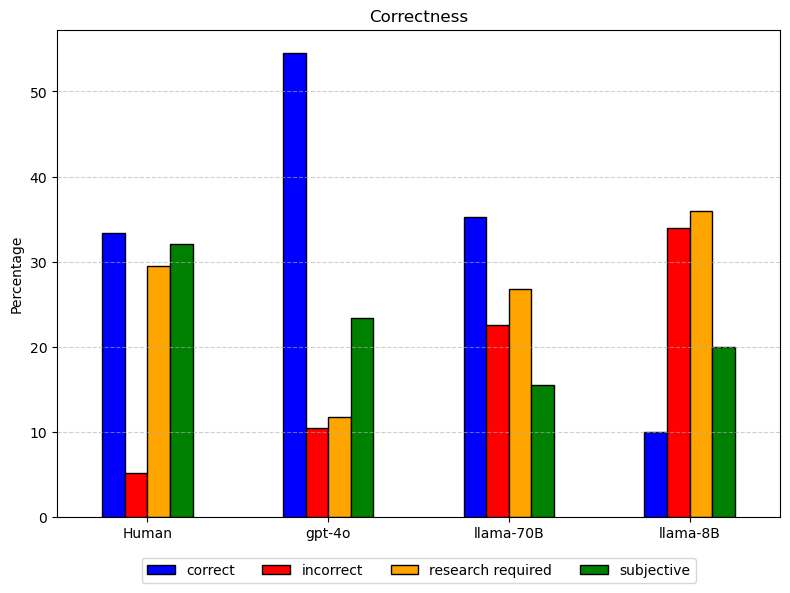

In [ ]:
import os
full_df = pd.concat([luca_df, tj_df])
fig = plot_human_eval(full_df, categories=["correctness"])
if False:
    plot_folder = os.path.abspath(r"/mnt/c/Users/nik_b/Documents/UZH/CL/Master_thesis_text/master-thesis/images/plots")
    # plot_folder = "../plots"
    plot_name = "humanEval-correctness.pdf"
    plt.savefig(os.path.join(plot_folder, plot_name), dpi=300, bbox_inches='tight',format='pdf')

In [168]:
tj_df[(tj_df["fact_check"]=="incorrect")&(tj_df["model"]=="Human")]

,letter_id,n_footnote,model,text_footnote,style,usefulness,correctness,fact_check,commentary,footnote_id
85,11012,3,Human,"Vgl. Röm 14, 5.",adequate,relevant,incorrect,incorrect,None,11012_3
107,11614,21,Human,"Nach Wasselnheim (Wasselonne, ""Waßelen""; s. eb...",adequate,partially relevant,incorrect,incorrect,None,11614_21


In [169]:
luca_df[(luca_df["fact_check"]=="incorrect")&(luca_df["model"]=="Human")]

,letter_id,n_footnote,model,text_footnote,style,usefulness,correctness,fact_check,commentary,footnote_id
26,12544,21,Human,Hand zu wordt: Sie geben vor.,adequate,relevant,incorrect,incorrect,None,12544_21
101,12322,12,Human,"Bullingers Vorhaben, die Vorrede seines Johann...",adequate,relevant,incorrect,incorrect,None,12322_12


In [170]:
luca_df[(luca_df["fact_check"]=="incorrect")&(luca_df["model"]=="gpt-4o")]

,letter_id,n_footnote,model,text_footnote,style,usefulness,correctness,fact_check,commentary,footnote_id
81,10172,2,gpt-4o,"Der Ausdruck ""carnis internitionem spiritus al...",inadequate,relevant,incorrect,incorrect,None,10172_2
98,11755,48,gpt-4o,Heinrich Bullinger hatte in seinem Kommentar z...,inadequate,partially relevant,incorrect,incorrect,None,11755_48
102,12322,12,gpt-4o,Bullinger bezieht sich hier auf seine geplante...,adequate,relevant,incorrect,incorrect,None,12322_12
134,11503,19,gpt-4o,"Das ""Erblehen"" (lat. Emphyteusis) beschreibt e...",inadequate,partially relevant,incorrect,incorrect,None,11503_19
145,11764,9,gpt-4o,Konrad Pellikan (1478–1556) war ein bedeutende...,inadequate,partially relevant,incorrect,incorrect,None,11764_9


In [171]:
luca_df[(luca_df["fact_check"]=="incorrect")&(luca_df["model"]=="llama-8B")]

,letter_id,n_footnote,model,text_footnote,style,usefulness,correctness,fact_check,commentary,footnote_id
28,11755,169,llama-8B,"Zwinglis Kommentar zum Matthäus, Zürich StA Bo...",inadequate,irrelevant,incorrect,incorrect,None,11755_169
61,13080,68,llama-8B,hochmüthig.,inadequate,relevant,incorrect,incorrect,None,13080_68
77,10368,10,llama-8B,mitwoch vor letare anno 1534.,inadequate,relevant,incorrect,incorrect,None,10368_10
80,10172,2,llama-8B,"Vgl. Adagia, 1, 2, 32 (LB I 137).",inadequate,relevant,research required,incorrect,"Zu Fn 1 ist zudem anzumerken, dass die Adagia ...",10172_2
104,11614,21,llama-8B,Zu verstehen: In eine andere Provinz.,inadequate,relevant,incorrect,incorrect,None,11614_21
108,10192,9,llama-8B,"Die Saloderner, s. HBLS II 6.",inadequate,relevant,incorrect,incorrect,None,10192_9
128,10237,15,llama-8B,In den vorausgegangenen Briefen Hallers wird d...,inadequate,irrelevant,incorrect,incorrect,None,10237_15
146,11764,9,llama-8B,Pellikan hatte im Jahre 1532 seine Kommentare ...,inadequate,partially relevant,incorrect,incorrect,None,11764_9
155,11537,34,llama-8B,Philippa von Hessen.,adequate,relevant,incorrect,incorrect,None,11537_34
156,11537,20,llama-8B,Rodolphus Ryff.,adequate,relevant,incorrect,incorrect,None,11537_20


In [10]:
tj_df = get_data_from_excel("human_eval/final_evaluation_form_TJ.xlsx", "human_eval/final_evaluation_model_key.xlsx")
transform_df(tj_df)
# fig = plot_human_eval(tj_df)

/home/niko/anaconda3/lib/python3.11/site-packages/openpyxl/reader/excel.py:228: UserWarning: Data Validation extension is not supported and will be removed
  ws_parser.bind_all()


,letter_id,n_footnote,model,text_footnote,style,usefulness,correctness,fact_check,commentary,footnote_id
0,11755,104,llama-70B,"Vgl. 1Kor 7, 25; 2Kor 8, 10; 1Tim 5, 14.",adequate,relevant,correct,correct,None,11755_104
1,11755,104,gpt-4o,"Der Ausdruck ""ad Kalendas Graecas"" stammt aus ...",inadequate,partially relevant,correct,correct,None,11755_104
2,11755,104,Human,"Vgl. 1Kor 7, 25.",adequate,relevant,correct,correct,None,11755_104
3,11755,104,llama-8B,"4, 1.",incomprehensible,irrelevant,None,None,None,11755_104
4,10052,38,llama-70B,"Vgl. 1 Kor 7, 1ff.",adequate,relevant,correct,correct,None,10052_38
...,...,...,...,...,...,...,...,...,...,...
155,11537,34,llama-8B,Philippa von Hessen.,adequate,relevant,incorrect,incorrect,None,11537_34
156,11537,20,llama-8B,Rodolphus Ryff.,adequate,relevant,research required,subjective,None,11537_20
157,11537,20,gpt-4o,"Die Erwähnung einer ""altera"" bezieht sich verm...",inadequate,irrelevant,research required,subjective,None,11537_20
158,11537,20,Human,Landgräfin Christine von Hessen.,adequate,relevant,research required,subjective,None,11537_20


# Correlation to automatic measures

In [ ]:
def scoring(df1, df2, model = "llama-70B"):
    
    score_df1 = calculate_ranking(df1)
    score_df1 = score_df1[score_df1["model"]==model]
    score_df2 = calculate_ranking(df2)
    score_df2 = score_df2[score_df2["model"]==model]



calculate_ranking(luca_df[luca_df["model"]=="llama-70B"], "style")

/tmp/ipykernel_6668/4229926057.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[f'{criteria}_score'] = df[criteria].map(scoring[criteria]).fillna(0)
/tmp/ipykernel_6668/4229926057.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['rank'] = df.groupby('footnote_id')[f'{criteria}_score'].rank(ascending=False, method='dense')


,footnote_id,model,style,style_score,rank
0,11755_104,llama-70B,adequate,2,1.0
4,10052_38,llama-70B,inadequate,1,1.0
8,12628_83,llama-70B,adequate,2,1.0
12,12552_17,llama-70B,adequate,2,1.0
16,10348_20,llama-70B,incomprehensible,0,1.0
22,10368_11,llama-70B,inadequate,1,1.0
27,12544_21,llama-70B,incomprehensible,0,1.0
29,11755_169,llama-70B,incomprehensible,0,1.0
32,12453_98,llama-70B,adequate,2,1.0
38,12982_3,llama-70B,incomprehensible,0,1.0


In [25]:
rank_1 = calculate_ranking(tj_df, "style")
calculate_average_ranking(luca_df, tj_df)

AttributeError: 'str' object has no attribute 'copy'